In [31]:
import ujson as json
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
results = 've-benchmarking/query_results/'

with open(results + "asr.json", "r") as f:
    results_asr = json.load(f)

with open(results + "caption.json", "r") as f:
    results_caption = json.load(f)

with open(results + "clip.json", "r") as f:
    results_clip = json.load(f)

with open(results + "ocr.json", "r") as f:
    results_ocr = json.load(f)

with open(results + "mix.json", "r") as f:
    results_mix = json.load(f)

In [61]:
def iou(query, candidate):
    # convert nanoseconds to seconds
    candidate_start = int(candidate["properties"]["start"]) / 1000000000.0
    candidate_end = int(candidate["properties"]["end"]) / 1000000000.0
    truth_start = query["segments"][0][0]
    truth_end = query["segments"][0][1]

    intersection = min(truth_end,candidate_end)-max(truth_start,candidate_start)
    if intersection < 0:
        # negative intersection = no overlap = IOU 0
        return 0.0
    
    union = (candidate_end-candidate_start) + (truth_end-truth_start) - intersection
    return intersection/union

In [100]:
def format_iou(query, method, rank):
    # considers only first result
    if "segments" in query["query"] and len(query["response"]["retrievables"])>0 and "start" in query["response"]["retrievables"][rank]["properties"]: 
        iou_score = iou(query["query"],query["response"]["retrievables"][rank])
        return {
            "iou": iou_score,
            "method": method,
            "class": query["query"]["tag"][0]
        }


In [101]:
def rank(query, candidates):
    truth = query["files"]
    rank = float("inf")
    for i in range(len(candidates)):
        cand_file = os.path.basename(candidates[i]["properties"]["path"])
        if cand_file in truth:
            rank = i+1
            break

    return rank

In [102]:
def format_mrr(query, method):
    if len(query["response"]["retrievables"]) > 0:
        res_rank = rank(query["query"], query["response"]["retrievables"])
        return {
            "rank": res_rank,
            "mrr": 1.0/res_rank,
            "method": method,
            "class": query["query"]["tag"][0]
        }

## Intersection-over-union for video retrievables, MRR for image retrievables

In [103]:
iou_results = []
mrr_results = []
for result in results_asr:
    iou_results.append(format_iou(result, "ASR", 0))
    mrr_results.append(format_mrr(result, "ASR"))


for result in results_caption:
    iou_results.append(format_iou(result, "Caption", 0))
    mrr_results.append(format_mrr(result, "Caption"))


for result in results_clip:
    iou_results.append(format_iou(result, "Clip", 0))
    mrr_results.append(format_mrr(result, "Clip"))


for result in results_ocr:
    iou_results.append(format_iou(result, "OCR", 0))
    mrr_results.append(format_mrr(result, "OCR"))


for result in results_mix:
    iou_results.append(format_iou(result, "Combined", 0))
    mrr_results.append(format_mrr(result, "Combined"))

In [106]:
[r for r in iou_results if r is not None]

[{'iou': 0.0, 'method': 'ASR', 'class': 'visual'},
 {'iou': 0.0, 'method': 'ASR', 'class': 'context'},
 {'iou': 0.3835877862595396, 'method': 'ASR', 'class': 'audio'},
 {'iou': 0.0, 'method': 'ASR', 'class': 'context'},
 {'iou': 0.04668930390492335, 'method': 'ASR', 'class': 'context'},
 {'iou': 0.6459999999999979, 'method': 'ASR', 'class': 'audio'},
 {'iou': 0.2684478371501285, 'method': 'ASR', 'class': 'context'},
 {'iou': 0.0, 'method': 'ASR', 'class': 'context'},
 {'iou': 0.0, 'method': 'ASR', 'class': 'context'},
 {'iou': 0.0, 'method': 'ASR', 'class': 'context'},
 {'iou': 0.0, 'method': 'ASR', 'class': 'visual'},
 {'iou': 0.0, 'method': 'ASR', 'class': 'audio'},
 {'iou': 0.0, 'method': 'ASR', 'class': 'visual'},
 {'iou': 0.0, 'method': 'ASR', 'class': 'visual'},
 {'iou': 0.0, 'method': 'Caption', 'class': 'visual'},
 {'iou': 0.0, 'method': 'Caption', 'class': 'context'},
 {'iou': 0.3597122302158272, 'method': 'Caption', 'class': 'context'},
 {'iou': 0.0, 'method': 'Caption', 'cla

In [109]:
mrr_df = pd.DataFrame([r for r in mrr_results if r is not None])
iou_df = pd.DataFrame([r for r in iou_results if r is not None])

In [110]:
cutoffs = [1,2,5,10,25,50,100,200]

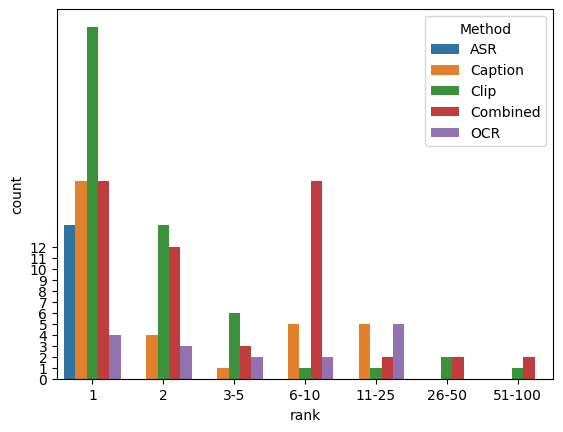

In [89]:
# Create a DataFrame with bins and counts for each method
hist_data = []
for method_group in mrr_df.groupby("method"):
    method_name, method_group = method_group
    counts, _ = np.histogram(method_group["rank"], bins=cutoffs)
    hist_data.extend({"method": method_name, "rank": bin, "count": count} for bin, count in zip(cutoffs, counts))

hist_df = pd.DataFrame(hist_data)

# Plotting side-by-side bars with the same width
sns.barplot(data=hist_df, x="rank", y="count", hue="method", dodge=True)

xticklabels = ["1", "2", "3-5", "6-10", "11-25", "26-50", "51-100"]
plt.xticks(range(len(xticklabels)), xticklabels)
plt.yticks(range(13))

# Add legend
plt.legend(title="Method")

# Show the plot
plt.show()

<Axes: xlabel='class', ylabel='iou'>

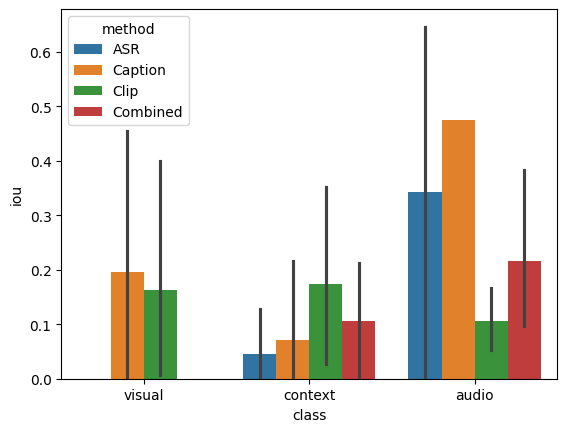

In [113]:
sns.barplot(data=iou_df, x="class", y="iou", hue="method", dodge=True)